## Preprocessing

In [33]:
# import libraries
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow import keras
import numpy as np
import os

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Dropout, Conv2DTranspose, Input
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split

In [4]:
# download data
width=420
height=540

def to_arrays(path, width=width, height=height):
    '''
    path: str 'data/train', 'data/test', etc
    '''
    array = []
    
    files = sorted(os.listdir(path))
    
    for i in files:
        # download images, change size and color_mode
        img = load_img(f'{path + "/" + i}', target_size=(width, height), color_mode='grayscale')
        
        # transform the image into a matrix and normalize it by 255
        img = img_to_array(img, dtype='float32')/255.
        array.append(img)
        
    return np.array(array)

x_train = to_arrays("/content/drive/MyDrive/Colab_Notebooks/denoising-dirty-documents/train")
x_train_cleaned = to_arrays("/content/drive/MyDrive/Colab_Notebooks/denoising-dirty-documents/train_cleaned")
x_test = to_arrays("/content/drive/MyDrive/Colab_Notebooks/denoising-dirty-documents/test")

## Data visualization

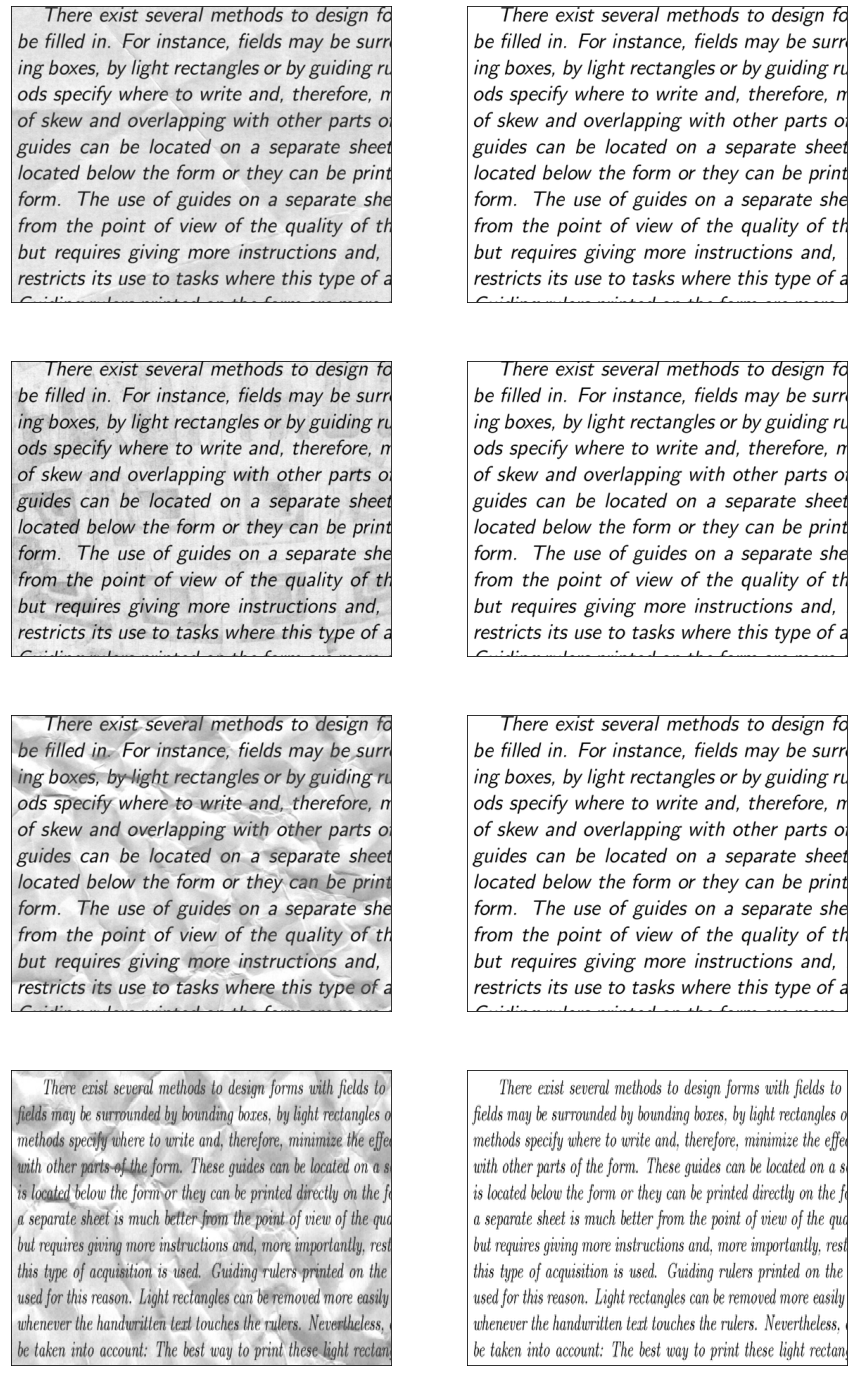

In [28]:
plt.figure(figsize=(15,25))
for i in range(0,8,2):
    plt.subplot(4,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_train[i][:,:,0], cmap='gray')
    
    plt.subplot(4,2,i+2)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_train_cleaned[i][:,:,0], cmap='gray')

plt.show()

In [ ]:
x_train.shape

(144, 420, 540, 1)

In [ ]:
x_train_cleaned.shape

(144, 420, 540, 1)

In [ ]:
x_test.shape

(72, 420, 540, 1)

In [31]:
X_train, X_val, y_train, y_val = train_test_split(x_train, x_train_cleaned, test_size=0.15)

## Autoencoder

In [34]:
conv_autoencoder = Sequential()

# Encoder
conv_autoencoder.add(Conv2D(filters=32, kernel_size=(3,3), input_shape=(420,540,1), activation='relu', padding='same'))
conv_autoencoder.add(MaxPooling2D((2, 2), padding='same'))

conv_autoencoder.add(Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same'))
conv_autoencoder.add(MaxPooling2D((2, 2), padding='same'))



# Decoder
conv_autoencoder.add(Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same'))
conv_autoencoder.add(Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'))


# Output
conv_autoencoder.add(Conv2D(filters=1, kernel_size=(3,3), activation='sigmoid', padding='same'))

conv_autoencoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 420, 540, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 210, 270, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 210, 270, 16)      4624      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 105, 135, 16)     0         
 2D)                                                             
                                                                 
 conv2d_transpose (Conv2DTra  (None, 210, 270, 8)      1160      
 nspose)                                                         
                                                        

## Train model

In [35]:
conv_autoencoder.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

early_stop = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
history= conv_autoencoder.fit(X_train, y_train, validation_data = (X_val, y_val), epochs=200, batch_size=16, callbacks= [early_stop])

Epoch 1/200
8/8 [==============================] - 15s 351ms/step - loss: 0.2202 - mae: 0.4559 - val_loss: 0.2171 - val_mae: 0.4534
Epoch 2/200
8/8 [==============================] - 1s 143ms/step - loss: 0.2093 - mae: 0.4446 - val_loss: 0.1991 - val_mae: 0.4345
Epoch 3/200
8/8 [==============================] - 1s 143ms/step - loss: 0.1802 - mae: 0.4125 - val_loss: 0.1482 - val_mae: 0.3736
Epoch 4/200
8/8 [==============================] - 1s 144ms/step - loss: 0.1131 - mae: 0.3135 - val_loss: 0.0751 - val_mae: 0.2178
Epoch 5/200
8/8 [==============================] - 1s 143ms/step - loss: 0.0729 - mae: 0.1671 - val_loss: 0.0748 - val_mae: 0.1289
Epoch 6/200
8/8 [==============================] - 1s 143ms/step - loss: 0.0768 - mae: 0.1258 - val_loss: 0.0761 - val_mae: 0.1228
Epoch 7/200
8/8 [==============================] - 1s 144ms/step - loss: 0.0759 - mae: 0.1284 - val_loss: 0.0726 - val_mae: 0.1371
Epoch 8/200
8/8 [==============================] - 1s 144ms/step - loss: 0.0714 - 

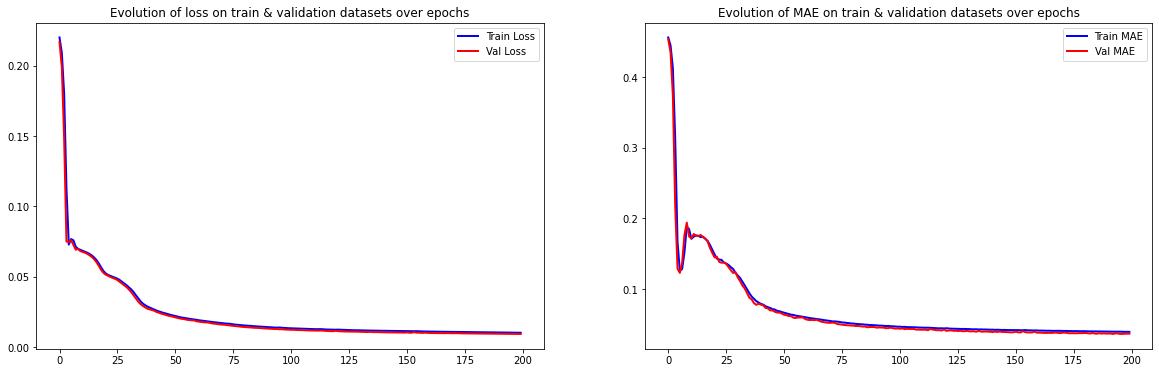

In [36]:
# Check how loss & mae went down
epoch_loss = history.history['loss']
epoch_val_loss = history.history['val_loss']
epoch_mae = history.history['mae']
epoch_val_mae = history.history['val_mae']

plt.figure(figsize=(20,6))
plt.subplot(1,2,1)
plt.plot(range(0,len(epoch_loss)), epoch_loss, 'b-', linewidth=2, label='Train Loss')
plt.plot(range(0,len(epoch_val_loss)), epoch_val_loss, 'r-', linewidth=2, label='Val Loss')
plt.title('Evolution of loss on train & validation datasets over epochs')
plt.legend(loc='best')

plt.subplot(1,2,2)
plt.plot(range(0,len(epoch_mae)), epoch_mae, 'b-', linewidth=2, label='Train MAE')
plt.plot(range(0,len(epoch_val_mae)), epoch_val_mae, 'r-', linewidth=2,label='Val MAE')
plt.title('Evolution of MAE on train & validation datasets over epochs')
plt.legend(loc='best')

plt.show()

In [37]:
y_pred = conv_autoencoder.predict(x_test, batch_size=16)

## Result visualization

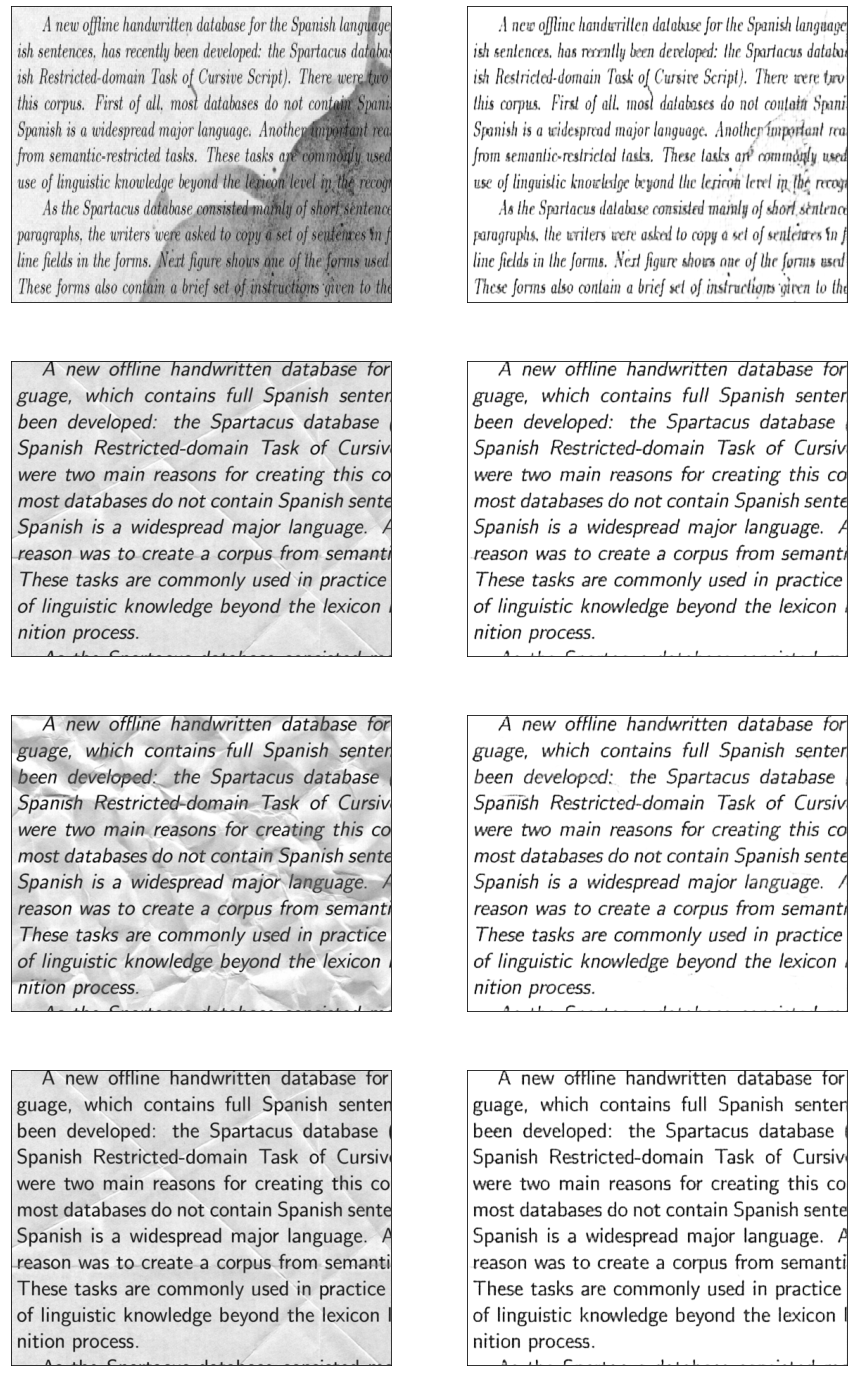

In [39]:
plt.figure(figsize=(15,25))
for i in range(0,8,2):
    plt.subplot(4,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[i][:,:,0], cmap='gray')
    
    plt.subplot(4,2,i+2)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(y_pred[i][:,:,0], cmap='gray')

plt.show()